In [83]:
import torch
import torchvision
from torch import functional as F
from torch import nn
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
for root, folders, images in os.walk("/Users/nilaygaitonde/Documents/Projects/capstone/celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/images"):
    print(images)

['052628.jpg', '161590.jpg', '195377.jpg', '192418.jpg', '013112.jpg', '081470.jpg', '193706.jpg', '147231.jpg', '054259.jpg', '148102.jpg', '109638.jpg', '157022.jpg', '183515.jpg', '111077.jpg', '197560.jpg', '067693.jpg', '153244.jpg', '006279.jpg', '132876.jpg', '191111.jpg', '142349.jpg', '057988.jpg', '155635.jpg', '038397.jpg', '026817.jpg', '155153.jpg', '114669.jpg', '039937.jpg', '145340.jpg', '011063.jpg', '112218.jpg', '193060.jpg', '148664.jpg', '176952.jpg', '004308.jpg', '118053.jpg', '185602.jpg', '099559.jpg', '081316.jpg', '166599.jpg', '032862.jpg', '086479.jpg', '091105.jpg', '107173.jpg', '159769.jpg', '195411.jpg', '177480.jpg', '158463.jpg', '005002.jpg', '193074.jpg', '043057.jpg', '063387.jpg', '184508.jpg', '098653.jpg', '148670.jpg', '055635.jpg', '074823.jpg', '045426.jpg', '175297.jpg', '051453.jpg', '017406.jpg', '061590.jpg', '008526.jpg', '191663.jpg', '103301.jpg', '009638.jpg', '047231.jpg', '016718.jpg', '154259.jpg', '093060.jpg', '163393.jpg', '0832

In [100]:
data_path = '/Users/nilaygaitonde/Documents/Projects/capstone/celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/'
images_folder = os.path.join(data_path, 'images')
train_file = "celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/triplets.csv"

# Load triplet data
data = pd.read_csv(train_file)
train_data = data[:int(data.shape[0]*0.6)]
test_data = data[int(data.shape[0]*0.6):]

In [107]:
def create_pairs_from_triplets(triplet_data):
    """
    Convert triplet data (anchor, positive, negative) to pairs with labels. 
    1 for dissimilar pairs and 0 for similar pairs.
    """
    pairs_data = []
    
    for i in range(len(triplet_data)):
        anchor = triplet_data.iloc[i, 0]
        positive = triplet_data.iloc[i, 2]
        negative = triplet_data.iloc[i, 4]
        
        pairs_data.append([anchor, positive, 0])
        
        pairs_data.append([anchor, negative, 1])
    
    return pd.DataFrame(pairs_data, columns=['img1', 'img2', 'label'])

train_data = create_pairs_from_triplets(train_data)

In [108]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, root_dir):
        self.data = data
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img1 = plt.imread(os.path.join(self.root_dir, self.data.iloc[idx, 0]))
        img1 = cv2.resize(img1, (224, 224))
        img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        img2 = plt.imread(os.path.join(self.root_dir, self.data.iloc[idx, 1]))
        img2 = cv2.resize(img2, (224, 224))
        img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
        label = self.data.iloc[idx, 2]
        return img1, img2, torch.FloatTensor([label])

dataset = Dataset(train_data,"/Users/nilaygaitonde/Documents/Projects/capstone/celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/images")
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [109]:
dataset[1179][0].shape

(224, 224)

tensor([1.])


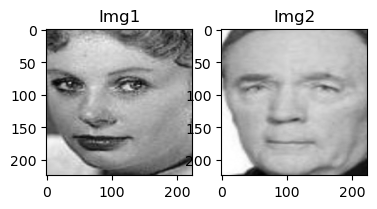

In [112]:
plt.subplot(1,3,1)
plt.imshow(dataset[1179][0],cmap="grey")
plt.title("Img1")
plt.subplot(1,3,2)
plt.imshow(dataset[1179][1],cmap="grey")
plt.title("Img2")
print(dataset[1179][2])

In [104]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 10),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(128, 128, 4),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(128, 256, 6),
            nn.ReLU(),
            nn.Flatten(),
            nn.BatchNorm1d(256*6*6)
        )
        self.fc_input_dim = 256 * 20 * 20
        
        # Fully connected layer for embedding
        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 4096),
            nn.Sigmoid()
        )

    def forward_one(self, x):
        return self.fc(self.cnn(x))
    
    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [94]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        
        loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + 
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return loss

In [ ]:
def training(model, train_loader, epochs=20, lr=0.001):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = ContrastiveLoss()

    best_val_loss = np.inf
    training_loss = []
    validation_loss = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        print(f"Training epoch {epoch+1}/{epochs}")
        for i, (img1, img2, label) in enumerate(train_loader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            optimizer.zero_grad()
            output1, output2 = model(img1, img2)
            loss = criterion(img1, img2, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print(f"Epoch {epoch+1}/{epochs}, Iteration {i+1}, Loss: {loss.item():.4f}")
            
        epoch_loss = running_loss / len(train_loader)
        training_loss.append(epoch_loss)

        print(f"Validating epoch {epoch+1}/{epochs}")
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (img1, img2, label) in enumerate(train_loader):
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)
                output1, output2 = model(img1, img2)
                loss = criterion(img1, img2, label)
                val_loss += loss.item()
                print(f"Epoch {epoch+1}/{epochs}, Iteration {i+1}, Loss: {loss.item():.4f}")
            val_loss /= len(train_loader)
            validation_loss.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Model saved with validation loss: {best_val_loss:.4f}")
    
    return model, training_loss, validation_loss

In [97]:
def calculate_accuracy(model, val_loader, threshold=0.5):
    device = torch.device("mps" if torch.backends.mps.is_available() else 
                        "cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    total = 0
    correct = 0
    
    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            
            # Get embeddings
            output1, output2 = model(img1, img2)
            
            # Calculate distance
            euclidean_distance = F.pairwise_distance(output1, output2)
            
            # If distance is less than threshold, predict same identity
            predictions = (euclidean_distance < threshold).float()
            
            # Calculate correct predictions (need to invert since label 0 means same identity in our dataset)
            correct += ((predictions == (1 - label)).sum().item())
            total += label.size(0)
    
    accuracy = correct / total
    return accuracy

In [ ]:
def main():
    